In [1]:
import sys
sys.path.append('../../')
sys.path.append('../../ray-delay')
from stim_surface_code.patch import SurfaceCodePatch
from stim_surface_code.memory import MemoryPatch
from stim_lattice_surgery.lattice_surgery.zxxz_patch import ZXXZPatch
from stim_lattice_surgery.lattice_surgery.glue import GluePatch, BoundaryType
from stim_lattice_surgery.lattice_surgery.surgery_op import SurgeryOp
from ray_delay.noise_model_patch import NoiseModelPatch
import numpy as np

In [2]:
d = 3
patch_control = ZXXZPatch(d, d, d, id_offset=0)
#patch_target = ZXXZPatch(d, d, d, id_offset=2*d**2)
patch_ancilla = ZXXZPatch(d, d, d, id_offset=2*d**2 - 1)

In [3]:
zz_op = SurgeryOp([patch_control, patch_ancilla], [], [(patch_control, BoundaryType.TOP, patch_ancilla, BoundaryType.BOTTOM, 4*d**2 - 2)])
#xx_op = SurgeryOp([patch_ancilla, patch_target], [], [(patch_ancilla, BoundaryType.RIGHT, patch_target, BoundaryType.LEFT, 6*d**2)])

In [4]:
#zz_op.patch_collection.set_error_vals_normal({'T1': 1, 'T2': 1, 'readout_err': -3, 'gate1_err': -3, 'gate2_err': -3})
cosmic_noise = NoiseModelPatch(zz_op.patch_collection)

In [5]:
display(zz_op.patch_collection)

------------------------------------
|    |    |X 26|    |    |    |    |
----------+----+--------------------
|    |  17|    |  18|    |  19|    |
----------+----+----+----+----+-----
|    |    |Z 27|    |X 28|    |Z 29|
----------+----+----+----+----+-----
|    |L 20|    |L 21|    |L 22|    |
-----+----+----+----+----+----------
|Z 30|    |X 31|    |Z 32|    |    |
-----+----+----+----+----+----------
|    |  23|    |  24|    |  25|    |
----------+----+----+----+----+-----
|    |    |Z 38|    |X 33|    |Z 40|
----------+----+----+----+----+-----
|    |  34|    |  35|    |  36|    |
-----+----+----+----+----+----------
|Z 37|    |X  9|    |Z 39|    |    |
-----+----+----+----+----+----------
|    |   0|    |   1|    |   2|    |
----------+----+----+----+----+-----
|    |    |Z 10|    |X 11|    |Z 12|
----------+----+----+----+----+-----
|    |L  3|    |L  4|    |L  5|    |
-----+----+----+----+----+----------
|Z 13|    |X 14|    |Z 15|    |    |
-----+----+----+----+----+----------
|

In [6]:
circ = zz_op.get_stim(init_basis='X', observable_basis='X', expect_bell=True)

In [7]:
dem = circ.detector_error_model(decompose_errors=True, approximate_disjoint_errors=True)

In [8]:
assert dem.num_detectors + dem.num_observables == circ.count_determined_measurements()

### Stim Simulations

In [9]:
import sinter
import matplotlib.pyplot as plt

In [10]:
p_range = [1e-4, 1e-3, 1e-2]
d_range = [5, 7, 9]
ray_radius = [4, 6, 8, 10]
init_basis = 'X'
observable_basis = 'Z'
tasks = []
for d in d_range:
    patch1 = ZXXZPatch(d, d, d, id_offset=0)
    patch2 = ZXXZPatch(d, d, d, id_offset=2*d**2 - 1)
    zz_op = SurgeryOp([patch1, patch2], [], [(patch1, BoundaryType.TOP, patch2, BoundaryType.BOTTOM, 4*d**2 - 2)])
    cosmic_noise = NoiseModelPatch(zz_op.patch_collection)
    #xx_op = SurgeryOp([patch1, patch2], [], [(patch1, BoundaryType.RIGHT, patch2, BoundaryType.LEFT, 4*d**2)])
    for p in p_range:
        cosmic_errors = cosmic_noise.noise_model.get_error_val_dict()
        zz_op.patch_collection.set_error_vals_normal({'T1': 1, 'T2': 1, 'readout_err': p, 'gate1_err': p, 'gate2_err': p, 'erasure':0})
        zz_op.patch_collection.error_vals['T1'] = cosmic_errors['T1']
        zz_op.patch_collection.error_vals['T2'] = cosmic_errors['T2']
        circ = zz_op.get_stim(init_basis=init_basis, observable_basis=observable_basis, expect_bell=True)
        tasks.append(sinter.Task(circuit=circ, json_metadata={'p': p, 'd': d}))

In [11]:
samples = sinter.collect(
    num_workers=4,
    max_shots=10_000_000,
    max_errors=100,
    tasks=tasks,
    decoders=['pymatching']
)

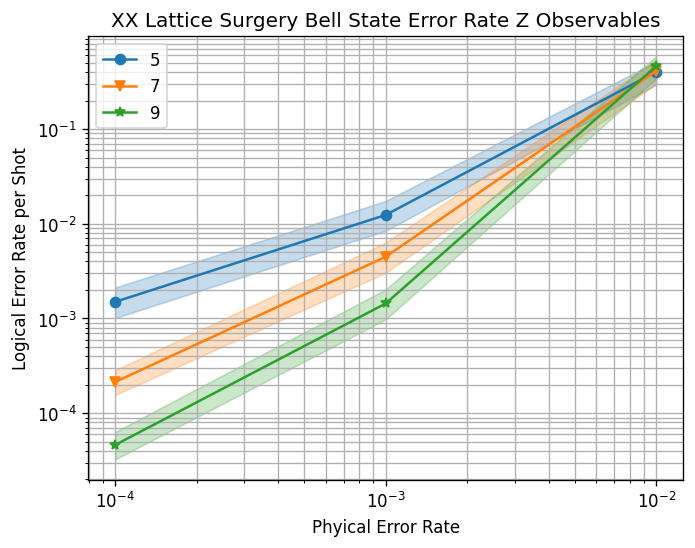

In [12]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=samples,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.loglog()
ax.set_title(f"XX Lattice Surgery Bell State Error Rate {observable_basis} Observables")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

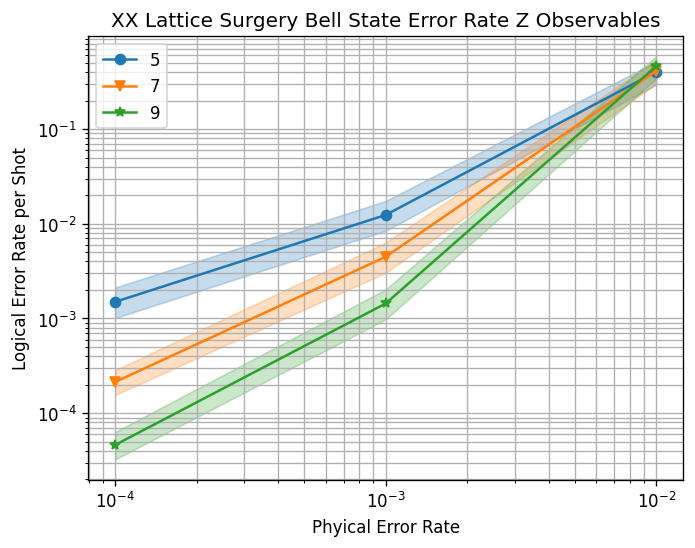

In [13]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=samples,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.loglog()
ax.set_title(f"XX Lattice Surgery Bell State Error Rate {observable_basis} Observables")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

In [17]:
patch_debug = ZXXZPatch(3, 3, 3, id_offset=0)
nop = SurgeryOp([patch_debug], [], [])
nop.patch_collection.set_error_vals_normal({'T1': 1, 'T2': 1, 'readout_err': 1e-3, 'gate1_err': 1e-3, 'gate2_err': 1e-3, 'erasure':0})

In [18]:
display(nop.patch_collection)

------------------------------------
|    |    |X  9|    |    |    |    |
----------+----+--------------------
|    |   0|    |   1|    |   2|    |
----------+----+----+----+----+-----
|    |    |Z 10|    |X 11|    |Z 12|
----------+----+----+----+----+-----
|    |L  3|    |L  4|    |L  5|    |
-----+----+----+----+----+----------
|Z 13|    |X 14|    |Z 15|    |    |
-----+----+----+----+----+----------
|    |   6|    |   7|    |   8|    |
--------------------+----+----------
|    |    |    |    |X 16|    |    |
------------------------------------

In [19]:
patch_debug.z_ancilla

[10, Coords: (2, 2), Basis: Z, Data Qubits: [0, Coords: (1, 1), 1, Coords: (1, 3), 3, Coords: (3, 1), 4, Coords: (3, 3)],
 12, Coords: (2, 6), Basis: Z, Data Qubits: [2, Coords: (1, 5), None, 5, Coords: (3, 5), None],
 13, Coords: (4, 0), Basis: Z, Data Qubits: [None, 3, Coords: (3, 1), None, 6, Coords: (5, 1)],
 15, Coords: (4, 4), Basis: Z, Data Qubits: [4, Coords: (3, 3), 5, Coords: (3, 5), 7, Coords: (5, 3), 8, Coords: (5, 5)]]

In [29]:
p_range = [1e-4, 1e-3, 1e-2]
d_range = [3, 5, 7]
init_basis = 'Z'
observable_basis = 'Z'
tasks = []
for d in d_range:
    patch_debug = MemoryPatch(d, d, d, id_offset=0)
    for p in p_range:
        patch_debug.set_error_vals_normal({'T1': np.inf, 'T2': np.inf, 'readout_err': p, 'gate1_err': 0, 'gate2_err': p, 'erasure':0})
        circ = patch_debug.get_stim(observable_basis=init_basis)
        tasks.append(sinter.Task(circuit=circ, json_metadata={'p': p, 'd': d}))

In [30]:
samples = sinter.collect(
    num_workers=4,
    max_shots=10_000_000,
    max_errors=100,
    tasks=tasks,
    decoders=['pymatching']
)

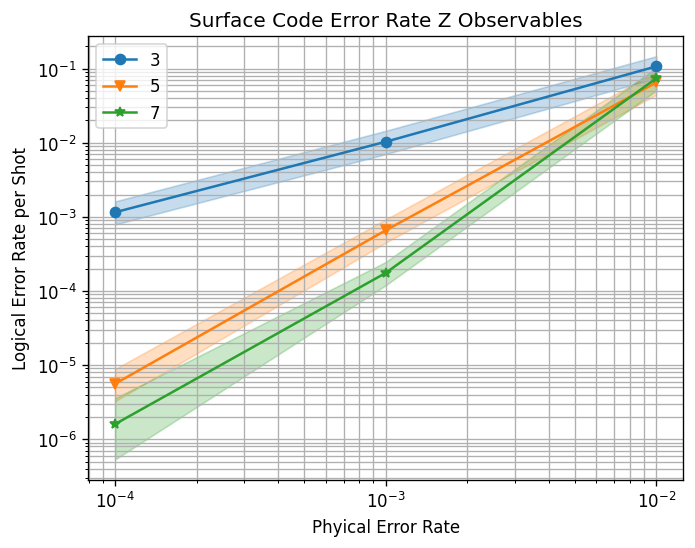

In [31]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=samples,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.loglog()
ax.set_title(f"Surface Code Error Rate {observable_basis} Observables")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

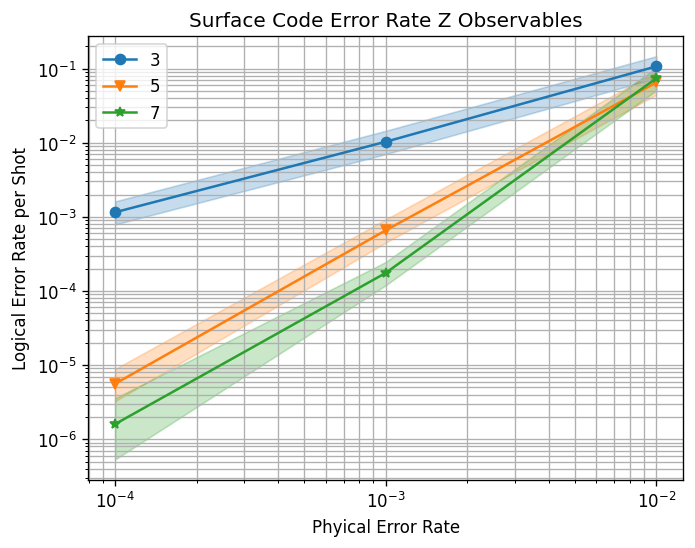

In [32]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=samples,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.loglog()
ax.set_title(f"Surface Code Error Rate {observable_basis} Observables")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

#### Cosmic Rays

In [36]:
p_range = [1e-4, 1e-3, 1e-2]
d_range = [5, 7, 9]
ray_radius = [4, 6, 8, 10, 12, 14, 16, 18, 20]
init_basis = 'X'
observable_basis = 'Z'
tasks = []
p = 1e-4
for d in d_range:
    patch1 = ZXXZPatch(d, d, d, id_offset=0)
    patch2 = ZXXZPatch(d, d, d, id_offset=2*d**2 - 1)
    zz_op = SurgeryOp([patch1, patch2], [], [(patch1, BoundaryType.TOP, patch2, BoundaryType.BOTTOM, 4*d**2 - 2)])
    cosmic_noise = NoiseModelPatch(zz_op.patch_collection)
    for rad in ray_radius:
        cosmic_noise.reset()
        cosmic_noise.force_cosmic_ray_by_coords((len(zz_op.patch_collection.device) // 2, len(zz_op.patch_collection.device[0]) // 2), rad)
        cosmic_errors = cosmic_noise.noise_model.get_error_val_dict()
        zz_op.patch_collection.set_error_vals_normal({'T1': 1, 'T2': 1, 'readout_err': p, 'gate1_err': p, 'gate2_err': p, 'erasure':0})
        zz_op.patch_collection.error_vals['T1'] = cosmic_errors['T1']
        zz_op.patch_collection.error_vals['T2'] = cosmic_errors['T2']
        circ = zz_op.get_stim(init_basis=init_basis, observable_basis=observable_basis, expect_bell=True)
        tasks.append(sinter.Task(circuit=circ, json_metadata={'rad': rad, 'p': p, 'd': d}))

In [37]:
samples = sinter.collect(
    num_workers=4,
    max_shots=10_000_000,
    max_errors=100,
    tasks=tasks,
    decoders=['pymatching']
)

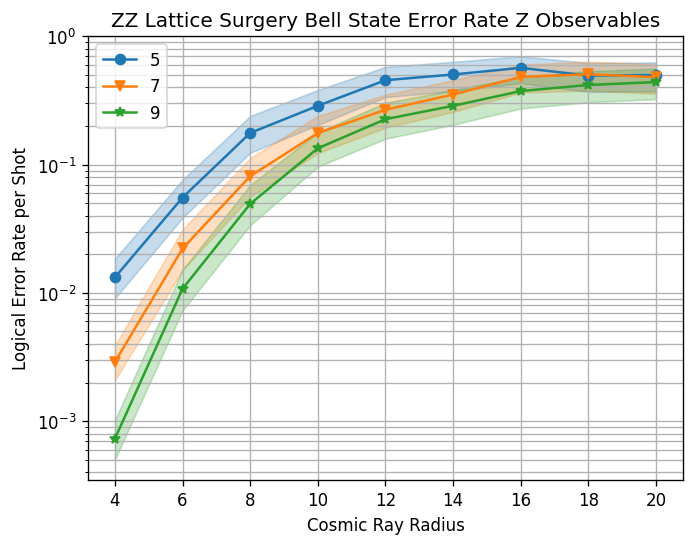

In [38]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=samples,
    x_func=lambda stats: stats.json_metadata['rad'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.set_yscale('log')
ax.set_title(f"ZZ Lattice Surgery Bell State Error Rate {observable_basis} Observables")
ax.set_xlabel("Cosmic Ray Radius")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

In [39]:
display(zz_op.patch_collection)

------------------------------------------------------------------------------------------------
|    |    |X242|    |    |    |X243|    |    |    |X244|    |    |    |X245|    |    |    |    |
----------+----+--------------+----+--------------+----+--------------+----+--------------------
|    | 161|    | 162|    | 163|    | 164|    | 165|    | 166|    | 167|    | 168|    | 169|    |
----------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----
|    |    |Z246|    |X247|    |Z248|    |X249|    |Z250|    |X251|    |Z252|    |X253|    |Z254|
----------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----
|    | 170|    | 171|    | 172|    | 173|    | 174|    | 175|    | 176|    | 177|    | 178|    |
-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----------
|Z255|    |X256|    |Z257|    |X258|    |Z259|    |X260|    |Z261|    |X262|    |Z263|    |    |
-----+----+----+----+----+----